gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

!pip install cellpose

from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

In [1]:
# Import modules
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from cellpose import models
from cellpose.io import imread
from cellpose import plot
from skimage.util import img_as_ubyte
import pandas as pd
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage import measure
import scipy
from scipy import ndimage as ndi
import cv2
from skimage.morphology import square, dilation
from sklearn.cluster import KMeans, DBSCAN
# https://stackoverflow.com/questions/19970764/making-feature-vector-from-gabor-filters-for-classification
# https://stackoverflow.com/questions/20608458/gabor-feature-extraction

# Image segmentation

In [4]:
#------------------------------------------------------
# Number of images we want to read. Only in test phase. If we want to read all images we will use len(Cherry_file) in for loop below
nb_images = 1

# Get path to folders containing images
Image_Directory = os.getcwd() + "\\20151218_E14_BM_mTF8additionals_4"
#Image_Directory = rC:\Users\Claudia\Desktop\Master EPFL\machine learning\project_2  #Easier for me (Alexis) than finding of to get my path file nicely
#Image_Directory = "/content/gdrive/MyDrive/ML_2_transcripted_cherry/TF1"
# other folders: 
# \\20151218_E14_BM_mTF8additionals_4

print(Image_Directory)

# Calculate number of document-> array containing 

# Create Lists containing datapath to all images of Cherry/ Ypet files
image_format = "tif"
cherry_condition = "TexasRed"
ypet_condition = "YFP"
Cherry_file = []
Ypet_file = []
test = []
TF_name_tot = []

# Walk through directory (call all files) and assign them to proper list
for root, dirs, files in os.walk(Image_Directory, topdown=False): # root = given in Input, dirs = folders, files= files
    for f in files:
        if f.endswith(image_format) and cherry_condition in f: 
            test.append(f)
            TF_name_tot.append(f.partition("(")[0])
            Cherry_file.append(os.path.join(root, f))
        elif f.endswith(image_format) and ypet_condition in f: 
            Ypet_file.append(os.path.join(root, f))


#assert len(Cherry_file) != len(Ypet_file), f"There are {len(Cherry_file)} Cherry files and {len(Ypet_file)} Ypet files. The number has to be equal, check manually what's missing"


# Initialize lists containing cherry, ypet images. Length = nb_images or len(Cherry_file) if we want to read all images
cherry_imgs = np.ndarray(nb_images,dtype = np.ndarray)
ypet_imgs = np.ndarray(nb_images,dtype = np.ndarray)


# Read image (We donnot add it in for loop above to enable reading subset of image)
for i in range(nb_images): #len(Cherry_file):
    cherry_imgs[i] = imread(Cherry_file[i])
    ypet_imgs[i] = imread(Ypet_file[i])
    
cherry_imgs = cherry_imgs.tolist()
ypet_imgs = ypet_imgs.tolist()

C:\Users\Sophia\Documents\EPFL\3rd_semester\Machine learning\project\P2\20151218_E14_BM_mTF8additionals_4


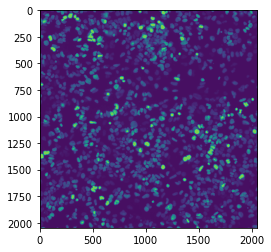

In [5]:
plt.imshow(imread(Ypet_file[0]))

In [6]:
# Definine parameters for cellpose module using nuclei modus
# https://cellpose.readthedocs.io/en/latest/settings.html
channels = [0,0] # Corresponds to greyscale image
diameter = None # Model was trained on diameters of 17 pixels. None-> automated estimation of the diameter. Can be changed by hand later
flow_threshold = 0.4 # maximum allowed error of the flows for each mask, default = 0.4
gpu = False
model_type='nuclei'

# Set model
model = models.Cellpose(gpu, model_type)

# Nuclei segmentation of all images within cherry_imgs list
masks, flows, styles, diams = model.eval(cherry_imgs, diameter=diameter, channels=channels, flow_threshold=flow_threshold, do_3D=False)


In [109]:
'''
from cellpose import io
import os
#os.mkdir("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1")
files_names = ["/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/img_"+str(i+1) for i in range(nb_images)]
io.masks_flows_to_seg(cherry_imgs, masks, flows, diams, files_names, channels)'''

'\nfrom cellpose import io\nimport os\n#os.mkdir("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1")\nfiles_names = ["/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/img_"+str(i+1) for i in range(nb_images)]\nio.masks_flows_to_seg(cherry_imgs, masks, flows, diams, files_names, channels)'

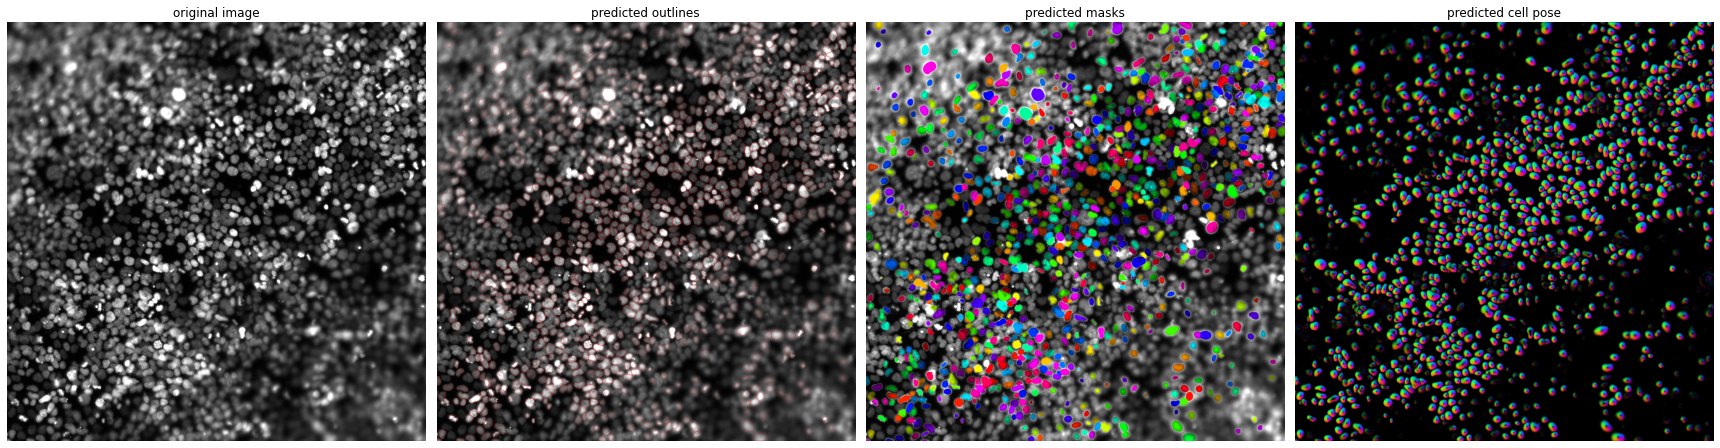

In [7]:
# Display results
image_i = 0 # Number of image we want to display. Max value= nb_images or len(Cherry_file)
fig = plt.figure(figsize=(24,8))
plot.show_segmentation(fig, cherry_imgs[image_i], masks[image_i], flows[image_i][0], channels)
plt.tight_layout()
plt.show()

***
# Feature extraction

In [8]:
def gabor_feature_extraction(kernels,patch_data):
    # Apply Gabor filter: We receive per kernel a response. We stack all the response to one matrix---------------------------------------------------------
    image = patch_data
    g_response = []

    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        g_response.append(filtered)
    n_clusters = len(g_response)
    g_response = np.vstack(g_response)

    # Cluster Gabor response with k-means. Find which part of the pixel belongs to which Gabor response ---------------------------------------------------------
    random_state = 1
    random.seed(random_state)
    kmean = KMeans(n_clusters, random_state=random_state).fit(g_response) #

    # Texton map: Assign each pixel to the identity of the closest cluster center---------------------------------------------------------
    histogram = np.histogram(kmean.labels_, bins = len(np.unique(kmean.labels_)))
    # Normalize
    gabor_feature = histogram[0] / histogram[0].sum()
    return gabor_feature

In [9]:
def feature_binary_pattern(patch_data):
    # Apply lbp
    METHOD = 'uniform' #  'default'
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(patch_data, n_points, radius, METHOD)
    
    # Create histogram
    count = len(np.unique(lbp))
    H, bins = np.histogram(lbp, count)

    # Drop background values
    w = width = radius - 1
    index_background = n_points - w
    H = H[0: index_background]
    bins =  bins[0: index_background]

    # plt.bar(bins,H,width=1)
    
    # Normalize
    lbp_feature = H / H.sum()
    return lbp_feature

In [10]:
from skimage.feature import local_binary_pattern
from skimage.color import label2rgb
from skimage.transform import rotate

In [11]:
# Initialize list of features 
columnname = ["" for i in range(1)]
patch_size = [0 for i in range(1)]
mean_intensity = [0 for i in range(1)]
sum_intensity = [0 for i in range(1)]
median_intensity = [0 for i in range(1)]
variance_intensity = [0 for i in range(1)]
imgs = [-1 for i in range(1)]

In [12]:
# prepare Gabor filter bank kernels---------------------------------------------------------
kernels = []
sigmas = [1,3]
tilts = [0,0.25,0.5,0.75] # perpendicular, diagonal, horizontal, other diagonal 
Wavelengths = [0.25,0.75] 
gamma =  0.5 # Spatial aspect ratio
psi = 0 # Phase offset.

for tilt in tilts:
    for sigma in sigmas:
        for lambd in Wavelengths:
            kernel = cv2.getGaborKernel((10,10), sigma, tilt, lambd, gamma, psi, ktype = cv2.CV_32F)
            kernels.append(kernel)

In [13]:
from skimage.feature import local_binary_pattern

In [31]:
# Extract feature of each nucleus within images nb_images
for j in range(nb_images):
    
    # Initialize features: Faster then appending values to list with append
    mask =  masks[j]  
    TF_name = TF_name_tot[j]
    start_nucleus = 1 # we have to at least start from 1, otherwise we take whole mask
    end_nucleus =  len(np.unique(mask)) # len(np.unique(mask))  #IMAGE SPECIFIC: cases where cell are big enough (sell last cell of the notebook)
    range_s = range(start_nucleus, end_nucleus)
    imgs = [j for i in range_s]
    ypet = ypet_imgs[j]
    columnname = ["" for i in range_s]
    blur = [False for i in range_s]
    patch_size = [0 for i in range_s]
    mean_intensity = [0 for i in range_s]
    sum_intensity = [0 for i in range_s]
    median_intensity = [0 for i in range_s]
    std_intensity = [0 for i in range_s]
    var_intensity = [0 for i in range_s]
    skew_intesity = [0 for i in range_s]
    kurt_intesity = [0 for i in range_s]
    iqr_intesity = [0 for i in range_s]
    entropy_intesity = [0 for i in range_s]
    gabor_features = [0 for i in range_s]
    lbp_features = [0 for i in range_s]
    blur_lapl = [False for i in range_s]
    blur_ski = [False for i in range_s]
                  
    #calculate different properties of the mask
    props = regionprops(mask)
    
    #initialize arrays to store information from the mask
    perimeter = [0 for i in range_s]
    feret_diameter_max = [0 for i in range_s]
    area_test = [0 for i in range_s]
    axis_major = [0 for i in range_s]
    axis_minor = [0 for i in range_s]
    solidity = [0 for i in range_s]

    '''
    # Iterate to explore and find good threshold in exploration phase
    patch_data_list = []
    variance_data_list = []'''
    # Threshold for blur detection
    var_threshold = 10000000
    blur_threshold = 0.7
    
    # Iterate through all nucleus: Take submatrix, Calculate patch size and corresponding ypet signal (mean) and store it into ypet_intensity
    iter_i = 0 # Ensures that no 0 are saved where patch is too small/big
    
    for i in range_s:# # Iterate through all nucleus: in range(start_nucleus, end_nucleus)
        cur = ypet[mask==i]
        patch_size_ = np.count_nonzero(~np.isnan(cur))
        
        # Extract subimage ----------------------------------------------------------------
        # Extract subimage of nucleus (Not just its values, which is done above)
        boolean = np.where(mask==i, 1,False) # Boolean matrix where patch = 1, else 0
        patch_values = ypet*boolean
        # Extract submatrix with a buffer of 3 pixels to calculate the blurrness
        variance_boolean = dilation(boolean, square(7))
        variance_values = ypet * variance_boolean
        
        # Drop pixels without nucleus information ----------------------------------------------------------------
        # Initialize conditions on when a column/ row should be dropped
        drop_nucleus = False
        drop_column = []
        drop_column_variance = []
        drop_row = []
        drop_row_variance = []
        
        
        # Iterate through all columns to find nucleus that is on the border and the columns that only contain mask
        for column in range(boolean.shape[1]):
            
            # drop nucleus if it's on the border 
            if (((column == 0) | (column == boolean.shape[1]-1)) & (np.any(boolean[:,column])== True)):
                drop_nucleus = True
                break 
                
            # drop if column has no information about nucleus: first check for broader variance_submatrix (Matrix with a buffer around submatrix to calculate variance). Then smaller submatrix 
            if np.any(variance_boolean[:,column])== False:
                drop_column_variance.append(column) 
                drop_column.append(column) 
            elif np.any(boolean[:,column])== False: 
                drop_column.append(column) 
        
        # Iterate through all columns to find nucleus that is on the border and the columns that only contain mask
        for row in range(boolean.shape[0]):
            
            # drop nucleus if it's on the border 
            if (((row == 0) | (row == boolean.shape[0]-1)) & (np.any(boolean[row,:])== True)):
                drop_nucleus = True
                break
                
            # drop if row has no information about nucleus:  first check for broader variance_submatrix  
            if np.any(variance_boolean[row,:])== False:
                drop_row.append(row)
                drop_row_variance.append(row)
            elif np.any(boolean[row,:])== False: 
                drop_row.append(row)
        
        # Drop pixels without nucleus information
        patch_data = np.delete(patch_values,drop_column,1)  
        patch_data = np.delete(patch_data,drop_row,0) 
        variance_data = np.delete(ypet,drop_column_variance,1)  
        variance_data = np.delete(variance_data,drop_row_variance,0) 
        
        '''
        # Exploration phase
        patch_data_list.append(patch_data)
        variance_data_list.append(variance_data)'''
        
        # Calculate blurness based on laplacian----------------------------------------------------------------
        var_lapl = cv2.Laplacian(variance_data, cv2.CV_64F).var()
        if var_lapl >= var_threshold: # nucleus is blurry
            blured_nucleus = True
        else: 
            blured_nucleus = False
        
        # Calculate blurness based on skimage----------------------------------------------------------------
        blur_ski_nucleus = measure.blur_effect(variance_data)
        if blur_ski_nucleus >= blur_threshold:
            blur_ski_temp = True
        else:
            blur_ski_temp = False
        
        # Feature calculation ----------------------------------------------------------------
        
        if ((patch_size_ > 10) & (patch_size_ < 50000) & (drop_nucleus== False)): 
            # extract intensity feature
            columnname[iter_i] = "patch_" + str(iter_i)    #We should not forgot that there is a -1 here. (when it is here)               
            patch_size[iter_i] = patch_size_
            blur_lapl[iter_i] = blured_nucleus
            blur_ski[iter_i] = blur_ski_temp
            sum_intensity[iter_i] = np.sum(np.sum(cur))
            mean_intensity[iter_i] = np.nanmean(cur)
            median_intensity[iter_i] = np.nanmedian(cur)
            
            std_intensity[iter_i] = np.nanstd(cur)
            var_intensity[iter_i] = np.nanvar(cur)
            skew_intesity[iter_i] = scipy.stats.skew(cur)
            kurt_intesity[iter_i] = scipy.stats.kurtosis(cur)
            iqr_intesity[iter_i] = scipy.stats.iqr(cur)
            entropy_intesity[iter_i] = scipy.stats.entropy(cur)
            
            gabor_features[iter_i] = gabor_feature_extraction(kernels,patch_data) # List of two arrays, first nb of counts in histogram, second: bin number
            temp_lbp = feature_binary_pattern(patch_data)
            lbp_features[iter_i]  = temp_lbp
            lbp_count = len(temp_lbp)
            
            perimeter[iter_i] = props[i-1].perimeter
            feret_diameter_max[iter_i] = props[i-1].feret_diameter_max
            area_test[iter_i] = props[i-1].area
            axis_major[iter_i] = props[i-1].major_axis_length
            axis_minor[iter_i] = props[i-1].minor_axis_length
            solidity[iter_i] = props[i-1].solidity
            
            iter_i +=1
    
    # Drop empty rows: some patches values were not calculated because their size is too small/big 
    if iter_i != range_s: # Some patches were not considered -> we have to drop those rows
        mean_intensity = mean_intensity[:iter_i]
        columnname = columnname[:iter_i]
        blur_lapl = blur_lapl[:iter_i]
        blur_ski = blur_ski[:iter_i]
        patch_size = patch_size[:iter_i]
        sum_intensity = sum_intensity[:iter_i]
        median_intensity = median_intensity[:iter_i]
        imgs = imgs[:iter_i]
        std_intensity = std_intensity[:iter_i] 
        var_intensity = var_intensity[:iter_i] 
        skew_intesity = skew_intesity[:iter_i] 
        kurt_intesity = kurt_intesity[:iter_i] 
        iqr_intesity = iqr_intesity[:iter_i]
        entropy_intesity = entropy_intesity[:iter_i] 
        gabor_features = gabor_features[:iter_i] 
        lbp_features = lbp_features[:iter_i] 
        
        perimeter = perimeter[:iter_i]
        feret_diameter_max = feret_diameter_max[:iter_i]
        area_test = area_test[:iter_i]
        axis_major = axis_major[:iter_i]
        axis_minor = axis_minor[:iter_i]
        solidity = solidity[:iter_i]
        
    ypet_intensity = pd.DataFrame(index=columnname)
    ypet_intensity['img'] = imgs
    ypet_intensity['TF_name'] = TF_name
    ypet_intensity['blur_lapl'] = blur_lapl
    ypet_intensity['blur_ski'] = blur_ski
    ypet_intensity['patch_size'] = patch_size
    ypet_intensity['mean_intensity'] = mean_intensity
    ypet_intensity['sum_intensity'] = sum_intensity
    ypet_intensity['median_intensity'] = median_intensity
    
    ypet_intensity['standard_deviation'] = std_intensity 
    ypet_intensity['variance'] = var_intensity
    ypet_intensity['skewness'] = skew_intesity
    ypet_intensity['kurtosis'] = kurt_intesity
    ypet_intensity['interquartile_range ']= iqr_intesity
    ypet_intensity['entropy'] = entropy_intesity
    ypet_intensity['Perimeter'] = perimeter 
    ypet_intensity['area_Test'] = area_test
    ypet_intensity['axis_major_length'] = axis_major
    ypet_intensity['feret_diameter_max'] = feret_diameter_max
    ypet_intensity['axis_minor_length'] = axis_minor
    ypet_intensity['solidity'] = solidity
    
    if imgs == []:
        print('All nucleis have been droppped. In order to extract features you need nucleus that are not by the border and not blurry.')
    else: 
        gabor_features_tot = np.vstack(gabor_features)
        lbp_features_tot = np.vstack(lbp_features)

        for filter_bank in range (len(kernels)):
            name = 'gabro_'+ str(filter_bank)
            ypet_intensity[name] = gabor_features_tot[:,filter_bank]


        for lbp_features_count in range (lbp_features_tot.shape[1]):
            name = 'lbp_' + str(lbp_features_count)
            ypet_intensity[name] = lbp_features_tot[:,lbp_features_count]
                                      
   
    #ypet_intensity_glob = pd.concat([ypet_intensity_glob,ypet_intensity])
    print("step "+str(j)+" over "+str(nb_images)+ " is done!")
    
    

C:\Users\Sophia\Programme\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Sophia\Programme\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


step 0 over 1 is done!


C:\Users\Sophia\Programme\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


### Add column with circularity

Formula for circularity: 4*pi*area/(perimeter^2)
Zero would mean that it is a circle. Everything else is between zero and one.

In [32]:
ypet_intensity['Circularity'] = (4*np.pi*ypet_intensity['patch_size'])/(ypet_intensity['Perimeter']**2)

In [33]:
ypet_intensity.head()

,img,TF_name,blur_lapl,blur_ski,patch_size,mean_intensity,sum_intensity,median_intensity,standard_deviation,variance,...,gabro_15,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,Circularity
patch_0,0,A - 1,False,False,983,4423.655137,4348453,2839.0,3111.904859,9.683952e+06,...,0.004934,0.136302,0.145749,0.110661,0.130904,0.170040,0.120108,0.072874,0.113360,0.885280
patch_1,0,A - 1,False,False,815,6564.204908,5349827,7561.0,2752.081685,7.573954e+06,...,0.006048,0.086257,0.096491,0.102339,0.163743,0.255848,0.128655,0.076023,0.090643,0.872776
patch_2,0,A - 1,False,False,499,9664.827655,4822749,9789.0,1686.611866,2.844660e+06,...,0.005859,0.089862,0.099078,0.094470,0.214286,0.188940,0.172811,0.076037,0.064516,0.879739


In [141]:
'''
path = '/content/drive/MyDrive/Project_2_ml/20151218_E14_BM_mTF8additionals_4/Features/features_cells_TF8_A1.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
    ypet_intensity_glob.to_csv(f)

"""  Was just to create the ~800 folders easier :)
import os
alphabet = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
for k in range(8):
  for j in range(8):
    for i in range(12):
      os.mkdir("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF"+str(k+1)+"/"+alphabet[j]+"_"+str(i+1))
"""

 to remove the "copie" part of it once I did copy
import os
os.rename("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/Copie de img_1_seg.npy","/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/img_1_seg.npy")
'''


'\npath = \'/content/drive/MyDrive/Project_2_ml/20151218_E14_BM_mTF8additionals_4/Features/features_cells_TF8_A1.csv\'\nwith open(path, \'w\', encoding = \'utf-8-sig\') as f:\n    ypet_intensity_glob.to_csv(f)\n\n"""  Was just to create the ~800 folders easier :)\nimport os\nalphabet = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]\nfor k in range(8):\n  for j in range(8):\n    for i in range(12):\n      os.mkdir("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF"+str(k+1)+"/"+alphabet[j]+"_"+str(i+1))\n"""\n\n to remove the "copie" part of it once I did copy\nimport os\nos.rename("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/Copie de img_1_seg.npy","/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/img_1_seg.npy")\n'

# With import run from here!

In [1]:
#Data importation (in case doesn't want to run above cells)
# Import modules
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from cellpose import models
from cellpose.io import imread
from cellpose import plot
from skimage.util import img_as_ubyte
import pandas as pd
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage import measure
import scipy
from scipy import ndimage as ndi
import cv2
from skimage.morphology import square, dilation
from sklearn.cluster import KMeans, DBSCAN
# https://stackoverflow.com/questions/19970764/making-feature-vector-from-gabor-filters-for-classification
# https://stackoverflow.com/questions/20608458/gabor-feature-extraction


#read matrices in
#ypet_intensity = pd.read_csv("../Features/TF1_C2.csv")




In [2]:
df = pd.read_csv ('../Features/TF1_C7.csv',index_col = 0)
ypet_intensity = df.copy()
ypet_intensity

,patch,img,TF_name,blur_lapl,blur_ski,patch_size,mean_intensity,sum_intensity,median_intensity,standard_deviation,...,gabro_15,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,Circularity
0,patch_6,1,C - 7,False,False,557,790.666068,440401,790.0,56.209692,...,0.006944,0.259459,0.167568,0.094595,0.102703,0.064865,0.083784,0.089189,0.137838,0.726082
1,patch_7,1,C - 7,False,False,739,1042.802436,770631,926.0,274.833903,...,0.046875,0.208835,0.178715,0.102410,0.128514,0.076305,0.078313,0.076305,0.150602,0.794946
2,patch_8,1,C - 7,False,False,680,841.535294,572244,831.0,89.429541,...,0.064338,0.247140,0.178490,0.091533,0.112128,0.089245,0.082380,0.064073,0.135011,0.853092
3,patch_9,1,C - 7,False,False,1234,870.455429,1074142,845.0,117.994204,...,0.004808,0.200000,0.201220,0.097561,0.100000,0.091463,0.080488,0.069512,0.159756,0.812795
4,patch_11,1,C - 7,False,False,1106,828.970163,916841,829.0,56.703426,...,0.019817,0.234890,0.192308,0.093407,0.081044,0.057692,0.086538,0.076923,0.177198,0.880464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5496,patch_505,12,C - 7,False,False,1298,828.140216,1074926,819.5,76.862345,...,0.023585,0.234524,0.176190,0.102381,0.100000,0.044048,0.075000,0.080952,0.186905,0.658896
5497,patch_506,12,C - 7,False,False,821,2108.556638,1731125,2109.0,157.649052,...,0.007353,0.221612,0.148352,0.120879,0.104396,0.087912,0.089744,0.089744,0.137363,0.908437
5498,patch_508,12,C - 7,False,False,1372,790.250000,1084223,757.0,130.311276,...,0.037500,0.219163,0.188326,0.105727,0.078194,0.075991,0.085903,0.085903,0.160793,0.596698
5499,patch_509,12,C - 7,False,False,1088,881.883272,959489,867.0,105.353520,...,0.034226,0.243243,0.194879,0.089616,0.072546,0.049787,0.079659,0.096728,0.173542,0.889439


# Preprocessing

## Parameters to adapt for the data processing

In [3]:
#parameters to adapt for analyzation:
#outlier removal
outlier = True              #If outliers in general should be removed True, if not False
interquantile = True        #if outliers should be removed by defining a range with the interquantile: True; to remove outliers just when they're exceeding a certain quantile: False
quantile_keep = 0.95        #to change if interquantile = False; else ignore
outlier_columns = ['mean_intensity'] #choose columns of which the outliers should be removed. to choose all the columns: list(ypet_intensity_processed)[6:]
outlier_range = 1.5         #if interquantile = True defined this value to define the range. Gets multiplicated with interquantile. Else ignore
#Normalization
normalization = True
columns_to_be_normalized =  ['mean_intensity','median_intensity','sum_intensity'] #list(ypet_intensity_processed)[6:]  #if all columns should be normalized
                            #take logs to reduce skewness
take_log = False             #want to take the log of certain columns
columns_log = ['mean_intensity'] #needs pre-analyzation of columns if log is needed. With a histogram it can be seen if the distribution is skewed. 
ypet_intensity_processed = ypet_intensity.copy()


## Outlier removal in columns of the dataframe

In [4]:
def outlier_removal(without_outliers, **kwargs):
    #define input parameters
    outlier_range =   kwargs['outlier_range']
    outlier_columns = kwargs['outlier_columns'] 
    interquantile =   kwargs['interquantile']
    quantile_keep =   kwargs['interquantile']
    # first choose which method for outlier removal wants to be used. Use a for loop to iterate over the defined columns of the dataframe.
    if interquantile == True:
        for col in outlier_columns:
            # defined the interquantile range and then the upper and lower limit of the choosen column
            median = without_outliers[col].median()
            q_75 = without_outliers[col].quantile(q = 0.75)
            q_25 = without_outliers[col].quantile(q = 0.25)
            interquantile = q_75 - q_25                              
            upper_bound = median + (interquantile * outlier_range)
            lower_bound = median - (interquantile * outlier_range)

            # Create a boolean mask that is True for rows with a value less than or equal to the upper limit and higher or equal to the lower limit
            mask = (without_outliers[col] <= upper_bound) & (without_outliers[col] >= lower_bound)
            # Use the mask to filter the dataframe
            without_outliers = without_outliers[mask]
    else: 
        for col in columns_outliers:
            #define the limit up to which the values are kept
            quantile_limit = without_outliers[col].quantile(q = quantile_keep)
            #define a boolean mask that is True for rows that are in the defined limit
            mask = without_outliers[col] <= quantile_limit
            #use the mask to filter the dataframe
            without_outliers = without_outliers[mask]
        
    return without_outliers


In [5]:
#apply the function for outlier removal
if outlier == True:
    #group by the TF and just cut the outliers for one TF
    without_outliers = ypet_intensity_processed.groupby('TF_name',as_index=False).apply(outlier_removal, outlier_range=outlier_range, outlier_columns=outlier_columns, interquantile = interquantile, quantile_keep=quantile_keep).reset_index()
    #change index so dataframe is as before
    without_outliers = without_outliers.drop(['level_0'],axis=1)
    without_outliers = without_outliers.set_index('level_1')
    without_outliers.index.name = None
    #save it under a new dataframe
    ypet_intensity_processed = without_outliers.copy()

## Take logarithm of certain columns to get rid of the skewness

In [6]:
#take logs of certain columns that are skewed
if take_log == True:
    TF_grouped = ypet_intensity_processed.groupby('TF_name')
    log_rows = TF_grouped[columns_log].transform(lambda x: np.log(x))
    ypet_intensity_processed[columns_log] = log_rows 

## Normalization of columns of the dataframe

In [7]:
# Normalization
if normalization == True:
    TF_grouped = ypet_intensity_processed.groupby('TF_name')
    Normalized_columns = TF_grouped[columns_to_be_normalized].transform(lambda x: (x - x.mean()) / x.std()) #removed rows_to_be to have all col normalized

    # Replace normalized
    ypet_intensity_processed[columns_to_be_normalized] = Normalized_columns                         


# Task 1

In [8]:
#import lybraries
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
import statsmodels.formula.api as smf
import seaborn as sns
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
from sklearn.metrics import r2_score
import warnings

In [9]:
print(list(ypet_intensity_processed))

['patch', 'img', 'TF_name', 'blur_lapl', 'blur_ski', 'patch_size', 'mean_intensity', 'sum_intensity', 'median_intensity', 'standard_deviation', 'variance', 'skewness', 'kurtosis', 'interquartile_range ', 'entropy', 'Perimeter', 'area_Test', 'axis_major_length', 'feret_diameter_max', 'axis_minor_length', 'solidity', 'similarity', 'hull area', 'correlation coef', 'gabro_0', 'gabro_1', 'gabro_2', 'gabro_3', 'gabro_4', 'gabro_5', 'gabro_6', 'gabro_7', 'gabro_8', 'gabro_9', 'gabro_10', 'gabro_11', 'gabro_12', 'gabro_13', 'gabro_14', 'gabro_15', 'lbp_0', 'lbp_1', 'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5', 'lbp_6', 'lbp_7', 'Circularity']


# Data exploration

## Scatterplots of different parameters compared to each other

Scatterplots (if you want with regression line (degree 1))

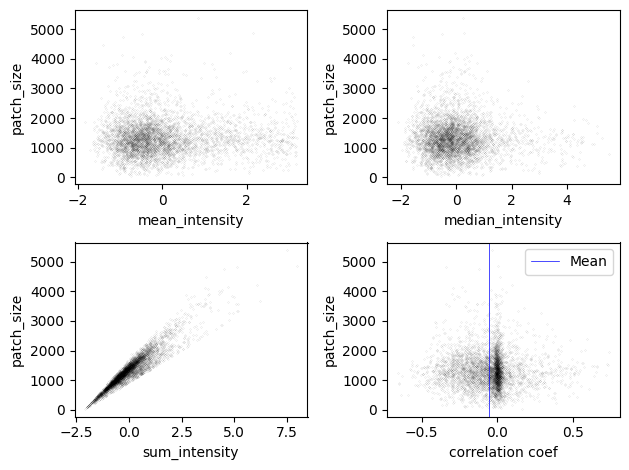

In [28]:
mk_size = 0.01 #Choose a small mk_size if a lot of datapoints, so densities are easier to read
points_col = 'black'
line_col   = 'blue'

plt.figure()
plt.subplot(221)
sns.regplot(y="patch_size", x="mean_intensity", data=ypet_intensity_processed,marker = '.',scatter_kws={'s':mk_size}, color = points_col, fit_reg=False)
plt.subplot(222)
sns.regplot(y="patch_size", x="median_intensity", data=ypet_intensity_processed,marker = '.',scatter_kws={'s':mk_size}, color = points_col, fit_reg=False)
plt.subplot(223)
sns.regplot(y="patch_size", x="sum_intensity", data=ypet_intensity_processed,marker = '.',scatter_kws={'s':mk_size}, color = points_col, fit_reg=False)
plt.subplot(224)
sns.regplot(y="patch_size", x="correlation coef", data=ypet_intensity_processed,marker = '.',scatter_kws={'s':mk_size}, color = points_col, fit_reg=False)
plt.axvline(np.mean(ypet_intensity_processed['correlation coef']),color = line_col,linewidth = 0.5,label = "Mean")
plt.legend()
plt.tight_layout()
plt.show()

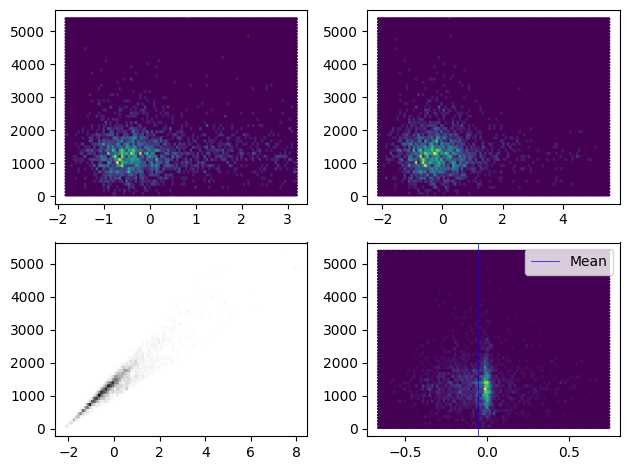

In [26]:

plt.figure()
plt.subplot(221)
plt.hexbin(x=ypet_intensity_processed["mean_intensity"],y=ypet_intensity_processed["patch_size"])
plt.subplot(222)
plt.hexbin(x=ypet_intensity_processed["median_intensity"],y=ypet_intensity_processed["patch_size"])
plt.subplot(223)
plt.hexbin(x=ypet_intensity_processed["sum_intensity"],y=ypet_intensity_processed["patch_size"],cmap = plt.cm.binary)
plt.subplot(224)
plt.hexbin(x=ypet_intensity_processed["correlation coef"],y=ypet_intensity_processed["patch_size"])
plt.axvline(np.mean(ypet_intensity_processed['correlation coef']),color = line_col,linewidth = 0.5,label = "Mean")
plt.legend()
plt.tight_layout()
plt.show()


## Parameters to define

In [112]:
maxdegree = 3                          #To define is the maximum degree of the polynomial that should be tried (maxdegree of 5 takes degree up to 4 into account)
x_features = ['mean_intensity','sum_intensity','correlation coef','median_intensity'] #define a list with all the columns that could be interesting for task 1
decide_x_features = np.array([1])      #set the list of indexes for the X values used for regression from list defined in test_features
decide_y_feature = 'patch_size'        #also other features could be taken into account


## Prepare test and train sets and X and y

In [113]:
#Define features used with the right format, following x_features and decide_x_features
features_used = [x_features[i] for i in decide_x_features]

# Split in train and test set
df_train, df_test = train_test_split(ypet_intensity_processed, train_size = 0.8, test_size = 0.2, random_state = 10)

#define the x and the y for the test and train sets
df_train_x = df_train[features_used]
df_test_x = df_test[features_used]

df_train_y = df_train[[decide_y_feature]]
df_test_y = df_test[[decide_y_feature]]

## Apply cross validation

In [114]:
#model to select
cross_validation_ridge_error = np.zeros(maxdegree)
cross_validation_lm_error = np.zeros(maxdegree)

#see which degree fits data the best for linear regression
for d in range(1, maxdegree+1):    #it will create 1,2...maxdregree range vector like this
    #polynomial feature expansion of x_train
    x_poly_train = PolynomialFeatures(degree=d).fit_transform(df_train_x)
    #apply linear regression model and cross-validation for alpha-ridge regression
    lr = LinearRegression()
    rr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
    #apply cross validation
    cve = cross_validate(lr,x_poly_train,df_train_y,scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    crr = cross_validate(rr,x_poly_train,df_train_y,scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    #make array for cross validation with linear model and for ridge regression
    cross_validation_lm_error[d-1] = np.mean(np.absolute(cve['test_score']))
    cross_validation_ridge_error[d-1] = np.mean(np.absolute(crr['test_score']))

## Choose best model

In [115]:
index_min_lm = np.argmin(cross_validation_lm_error)
index_min_ridge = np.argmin(cross_validation_ridge_error)

poly_lm_test = PolynomialFeatures(degree=index_min_lm+1)
x_poly_test_lm = poly_lm_test.fit_transform(df_test_x)
poly_lm_train = PolynomialFeatures(degree=index_min_lm+1)
x_poly_train_lm = poly_lm_train.fit_transform(df_train_x)

x_poly_train_df_lm = pd.DataFrame(x_poly_train_lm)
x_poly_test_df_lm = pd.DataFrame(x_poly_test_lm)

poly_ridge_test = PolynomialFeatures(degree=index_min_ridge+1)
x_poly_test_ridge = poly_ridge_test.fit_transform(df_test_x)
poly_ridge_train = PolynomialFeatures(degree=index_min_ridge+1)
x_poly_train_ridge = poly_ridge_train.fit_transform(df_train_x)

x_poly_train_df_ridge = pd.DataFrame(x_poly_train_ridge)
x_poly_test_df_ridge = pd.DataFrame(x_poly_test_ridge)

#make linear model
model_lm = LinearRegression().fit(x_poly_train_df_lm, df_train_y)
model_ridge = RidgeCV(alphas=[1e-4,1e-3, 1e-2, 1e-1, 1]).fit(x_poly_train_df_ridge, df_train_y)

#train error
y_train_pred_lm = model_lm.predict(x_poly_train_lm)
mse_train_lm = mean_squared_error(df_train_y,y_train_pred_lm)
y_train_pred_ridge = model_ridge.predict(x_poly_train_ridge)
mse_train_ridge = mean_squared_error(df_train_y,y_train_pred_ridge)

#test error
y_test_pred_lm = model_lm.predict(x_poly_test_df_lm)
mse_test_lm = mean_squared_error(df_test_y,y_test_pred_lm)
y_test_pred_ridge = model_ridge.predict(x_poly_test_df_ridge)
mse_test_ridge = mean_squared_error(df_test_y,y_test_pred_ridge)

## Visualize the best model and give back the parameters

In [116]:
df_plot_sort = pd.DataFrame(df_test_x)
df_plot_sort['reg'] =  y_test_pred_lm[:,0]
df_plot_sort.sort_values(features_used[0],inplace = True)

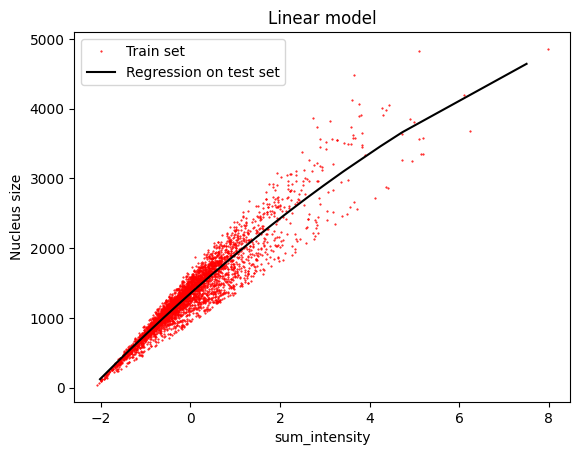

' OLD WAY TO PLOT IT (if need to go back)\n#show predicted points with linear model\nplt.plot(df_train_x,df_train_y, \'ro\')\nplt.plot(df_test_x,y_test_pred_lm, \'o\',color = \'black\')\n#plt.yscale("log")\n#plt.xscale("log")\nplt.show()\n'

In [117]:
#show predicted points with linear model

if (len(features_used)!=1):
    warnings.warn("WARNING features_used should be of len 1 for this plot")
else:
    plt.figure()
    plt.plot(df_train_x,df_train_y, 'r.',markersize = 1,label = "Train set")
    plt.plot(df_plot_sort[features_used[0]],df_plot_sort['reg'],color = 'black',label = "Regression on test set")
    plt.ylabel("Nucleus size")
    plt.xlabel(features_used[0])    #WARNING features_used should be of len 1 for this plot
    plt.title("Linear model")
    plt.legend()
    #plt.yscale("log")
    #plt.xscale("log")
    plt.show()


''' OLD WAY TO PLOT IT (if need to go back)
#show predicted points with linear model
plt.plot(df_train_x,df_train_y, 'ro')
plt.plot(df_test_x,y_test_pred_lm, 'o',color = 'black')
#plt.yscale("log")
#plt.xscale("log")
plt.show()
'''

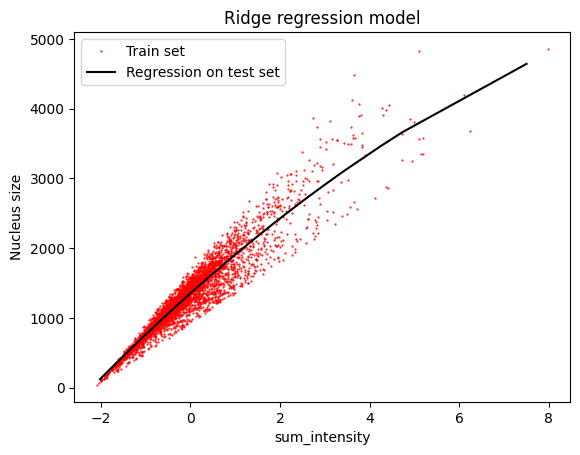

'\n#show predicted points with ridge regression\nplt.plot(df_train_x,df_train_y, \'ro\')\nplt.plot(df_test_x,y_test_pred_ridge, \'o\',color = \'black\')\n#plt.yscale("log")\n#plt.xscale("log")\nplt.show()\n'

In [142]:
#show predicted points with linear model
df_plot_sort_ridge = pd.DataFrame(df_test_x)
df_plot_sort_ridge['reg'] =  y_test_pred_ridge[:,0]
df_plot_sort_ridge.sort_values(features_used[0],inplace = True)

if (len(features_used)!=1):
    warnings.warn("WARNING features_used should be of len 1 for this plot")
else:
    plt.figure()
    plt.plot(df_train_x,df_train_y, 'r.',markersize = 1,label = "Train set")
    plt.plot(df_plot_sort_ridge[features_used[0]],df_plot_sort_ridge['reg'],color = 'black',label = "Regression on test set")
    plt.ylabel("Nucleus size")
    plt.xlabel(features_used[0])    #WARNING features_used should be of len 1 for this plot
    plt.title("Ridge regression model")
    plt.legend()
    #plt.yscale("log")
    #plt.xscale("log")
    plt.show()

''' OLD WAY TO PLOT IT (if need to go back)
#show predicted points with ridge regression
plt.plot(df_train_x,df_train_y, 'ro')
plt.plot(df_test_x,y_test_pred_ridge, 'o',color = 'black')
#plt.yscale("log")
#plt.xscale("log")
plt.show()
'''


## Output of the coefficients 

In [119]:
if mse_test_ridge >= mse_test_lm:
    feature_names = poly_lm_test.get_feature_names_out(input_features=features_used)
    print('take linear regression')
    print('features: ',feature_names)
    print('coefficients: ',model_lm.coef_)
    print('intercept: ',model_lm.intercept_)
    print('R^2-score: ', r2_score(df_train_y,y_train_pred_lm))
    

else:
    feature_names = poly_ridge_test.get_feature_names_out(input_features=features_used)
    print('take ridge regression')
    print('features: ',feature_names)
    print('coefficients: ',model_ridge.coef_)
    print('intercept: ',model_ridge.intercept_)
    print('alpha: ',model_ridge.alpha_)
    print('R^2-score: ', r2_score(df_train_y,y_train_pred_ridge))

take ridge regression
features:  ['1' 'sum_intensity' 'sum_intensity^2']
coefficients:  [[  0.         573.51564402 -17.96139116]]
intercept:  [1349.91514389]
alpha:  0.01
R^2-score:  0.8975946846636197


***

# Task 2: Unsupervised clustering

In [38]:
#import lybraries needed
from sklearn.decomposition import PCA
import math
from sklearn.cluster import KMeans

### Parameters to define

In [39]:
apply_preprocessing = True #True if it should be applied. False if no preprocessing should be applied. 
n_components = 2 #For PCA how many components to keep at the end
pca_excluded = ['img', 'TF_name', 'blur_lapl', 'blur_ski','patch'] #define which columns should be excluded -> No additional information for the PCA
random_state = 42 #input for the Kmeans algorithm to determines random number generation for centroid initialization
n_clusters = 5 # Number of clusters we want for TF


### Preprocessing

In [40]:
#apply data preprocessing steps
if (apply_preprocessing):
    ypet_intensity = ypet_intensity_processed

In [41]:
#Check how many datapoints each TF has and which TF has least values. Take according to that some random points.  (So that we have the same amount of datapoint for each TF). 
min_d =  ypet_intensity.groupby('TF_name').count().min()[0]


#take same amount of points per TF
TF_names = ypet_intensity.TF_name.unique()
extracted_i = []

for i in (TF_names):
    # indices of all the points from X that belong to cluster i
    C_i = np.where(ypet_intensity.TF_name == i)[0].tolist() 

    # indices of the points from X to be sampled from cluster i
    sample_i = np.random.choice(C_i, min_d,replace=False).tolist()
    extracted_i.extend(sample_i) 
extracted_points = ypet_intensity.iloc[extracted_i]   

In [42]:
extracted_points

,patch,img,TF_name,blur_lapl,blur_ski,patch_size,mean_intensity,sum_intensity,median_intensity,standard_deviation,...,gabro_15,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,Circularity
7778,patch_586,12,D - 8,False,False,3049,0.729469,2626836,825.0,139.607872,...,0.003571,0.213953,0.179328,0.113695,0.087339,0.077519,0.092506,0.079587,0.156072,0.878038
4129,patch_798,6,D - 8,False,False,960,0.144604,789410,825.0,80.305643,...,0.534539,0.215434,0.210611,0.081994,0.117363,0.080386,0.070740,0.075563,0.147910,0.856055
4708,patch_110,8,D - 8,False,False,978,-0.801046,745827,761.0,67.908258,...,0.004573,0.227202,0.185471,0.108192,0.098918,0.066461,0.074189,0.068006,0.171561,0.882900
3131,patch_535,5,D - 8,False,False,1652,0.616328,1410488,799.0,168.056970,...,0.004545,0.210238,0.179159,0.108775,0.084095,0.093236,0.095064,0.074040,0.155393,0.846859
571,patch_602,1,D - 8,False,False,1957,-0.241779,1560444,796.0,59.586884,...,0.005580,0.242653,0.204030,0.101595,0.081444,0.052897,0.057935,0.080605,0.178841,0.894803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911,patch_558,3,D - 8,False,False,2152,-1.643124,1534597,713.0,55.453430,...,0.055970,0.234104,0.180636,0.102601,0.076590,0.058526,0.085983,0.088873,0.172688,0.809704
1253,patch_603,2,D - 8,False,False,2564,-1.293161,1880111,727.0,67.363001,...,0.038462,0.224328,0.196822,0.091076,0.086797,0.066015,0.078851,0.085575,0.170538,0.873806
3710,patch_365,6,D - 8,False,False,1482,-0.503744,1157279,778.0,59.627493,...,0.004167,0.226987,0.184100,0.102510,0.089958,0.051255,0.100418,0.073222,0.171548,0.839378
3280,patch_685,5,D - 8,False,False,669,0.836196,581294,836.0,141.096582,...,0.004032,0.238532,0.190367,0.103211,0.077982,0.071101,0.073394,0.075688,0.169725,0.835237


### Apply a principal component analysis (PCA) and prepare dataframe for clustering

In [43]:
pca = PCA(n_components)
ypet_intensity = extracted_points

# define which columns should be excluded
to_test = ypet_intensity.drop(pca_excluded, axis = 1)

# Check how much variance the PCA components explain
pca_result = pca.fit(to_test)
print(pca_result.explained_variance_ratio_)

# apply the dimensionality reduction on data
pca_components = pca.fit_transform(to_test)

# Combine excluded data and pca
ypet_intensity_pca = ypet_intensity[pca_excluded]
for iter_i in range(n_components):
    name = 'pca_component_' + str(iter_i)
    ypet_intensity_pca[name] = pca_components[:,iter_i]

[0.99873088 0.00126897]


C:\Users\alexi\AppData\Local\Temp\ipykernel_15736\2993404782.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ypet_intensity_pca[name] = pca_components[:,iter_i]
C:\Users\alexi\AppData\Local\Temp\ipykernel_15736\2993404782.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ypet_intensity_pca[name] = pca_components[:,iter_i]


In [44]:
ypet_cluster = ypet_intensity_pca.reset_index().set_index(['index','patch','img','TF_name','blur_lapl','blur_ski'])

### Apply Kmean clustering algorithm

In [45]:
#apply KMeans algorithm
kmean = KMeans(n_clusters=n_clusters, random_state=random_state).fit(ypet_cluster)

#save as new dataframe and add column for clustering label
ypet_clustered = ypet_cluster.copy()
ypet_clustered['cluster'] = kmean.labels_

### Visualization of the results

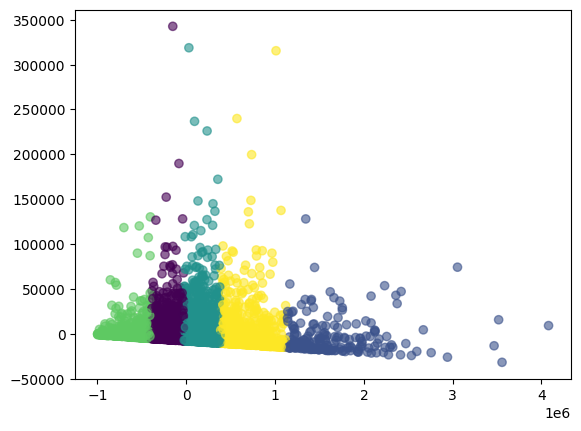

In [46]:
plt.scatter(ypet_cluster.iloc[:,0], ypet_cluster.iloc[:,1], c=kmean.labels_, alpha=0.6)

### Analysis of the results

In [47]:
# Find more information
min_n = ypet_clustered.groupby('cluster').count().min()[0] #min number of points i n a cluster
max_n = ypet_clustered.groupby('cluster').count().max()[0] #min number of points i n a cluster
min_n, max_n

(217, 2441)

In [48]:
test = ypet_clustered[ypet_clustered['cluster'] == 0]
test.groupby('TF_name').count()

,pca_component_0,pca_component_1,cluster
TF_name,,,
D - 8,2441,2441,2441


In [49]:
test = ypet_clustered[ypet_clustered['cluster'] == 3]
test.groupby('TF_name').count()

,pca_component_0,pca_component_1,cluster
TF_name,,,
D - 8,1211,1211,1211


In [50]:
# Extract x percentage of data per cluster -> easier to analyze
extracted_i = []
x = 0.9

for i in range(n_clusters):

    # indices of all the points from X that belong to cluster i
    C_i = np.where(kmean.labels_ == i)[0].tolist() 
    n_i = len(C_i) # number of points in cluster i

    # indices of the points from X to be sampled from cluster i
    sample_i = np.random.choice(C_i, math.ceil((x * n_i))).tolist()
    extracted_i.extend(sample_i) 
    

In [51]:
ypet_clustered.iloc[np.unique(extracted_i)]

,,,,,,pca_component_0,pca_component_1,cluster
index,patch,img,TF_name,blur_lapl,blur_ski,,,
4129,patch_798,6,D - 8,False,False,-254563.846551,-2218.307453,0
571,patch_602,1,D - 8,False,False,516432.697803,-10534.740266,4
7135,patch_678,11,D - 8,False,False,-83942.907365,-3599.384324,0
4677,patch_78,8,D - 8,False,False,-232085.871337,-5473.174495,0
3371,patch_14,6,D - 8,False,False,-408339.340049,-4160.580125,3
...,...,...,...,...,...,...,...,...
1445,patch_77,3,D - 8,False,False,-23150.838155,-6988.078591,2
7631,patch_433,12,D - 8,False,False,-8768.804750,7459.910821,2
1253,patch_603,2,D - 8,False,False,836100.246905,-11795.597044,4


***
# Visualizations (Exploration phase)

#### Tune blur

plt.imshow(cv2.Laplacian(variance_data_list[test], cv2.CV_64F), cmap='gray')


for i in range(1,100), image E-7

Not blurred:
variance_data_list[-1] -> 1'763'695
variance_data_list[-10] -> 3'056'590
variance_data_list[-10] -> 3'056'590
[-17] -> 1'056'899
[-20] -> 567'588
[-21] -> 2'138'449
[-23] -> 5'134'705
[-33] 30'821'019


Right classified with other nucleus near:
variance_data_list[-6] -> 25'095'309
variance_data_list[-13] ->5'698'016
[-16] -> 9'219'300
[-19] -> 11'049'582
[-25] -> 2'313'727
[-26] -> 157'114'853
[-27] -> 10'010'503
[-28] -> 3'063'935
[-31] -> 1'803'048
9'826'707


Wrongly classified:
variance_data_list[-6] -> 25'095'309
variance_data_list[-9] -> 57'898'307
[-14] -> 21'739'451
[-15] -> 6'769'331
[-30] -> 12'627'256


Overlay:
variance_data_list[-4] -> 34'614'946
[-22] -> 12'964'725
[-29] -> 17'727'949

Blurr/ overflow:
[-18] -> 283'062'008
[-24] -> 17'935'490

In [52]:
cv2.Laplacian(variance_data_list[test], cv2.CV_64F).var()

NameError: name 'variance_data_list' is not defined

In [ ]:
measure.blur_effect(variance_data_list[test])

#### Mask, nucleus

In [ ]:
plt.imshow(boolean, cmap='gray')

In [ ]:
plt.imshow(patch_data, cmap='gray')

In [ ]:
test = 31
plt.imshow(variance_data_list[test], cmap='gray')

In [ ]:
plt.imshow(patch_data_list[test], cmap='gray')

## Local binary patterns

In [ ]:
# Visualize lpb
METHOD = 'uniform'   
radius = 1
n_points = 8 * radius
image = patch_data

lbp = local_binary_pattern(image, n_points, radius, METHOD)

    
def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')
def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')



In [ ]:
# Remove background    

# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) # Remove background: list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)



for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)   
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

# Drop background
count = len(np.unique(lbp))
H, bins = np.histogram(lbp, count)

# Drop background values
fig, ax = plt.subplots(figsize=(12, 8))
index_background = n_points - w
H = H[0: index_background]
bins =  bins[0: index_background]

plt.bar(bins,H,width=1)